In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


57344/57026 [==============================] - 0s 9us/step


In [3]:
print(train_data.shape, test_data.shape)
# 데이터 규모가 적음! 따라서 신경망 구성 시 과대적합을 피하기 위해 작은 모델을 사용해야함(유닛,은닉층 수)

(404, 13) (102, 13)


### 데이터 정규화

In [4]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std
#데어터의 특성 스케일 값이 다름, 0~1사이 비율, 1~12 값을 가지는 등
# ( 입력데이터 - 특성 평균 )/ 표준편차

In [5]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                          input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1)) # 활성화 함수가 없음! 선형층, 전형적인 스칼라 회귀를 위한 구성임
    model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])# 손실함수 : 평균제곱 오차, 평균절대오차(mae) 0.5면 500달러정도 차이
    return model


### K-겹 검증하기 / 검증set 분할에 대한 검증 점수의 분산이 높다? 즉 검증 data 규모가 작을때 사용

In [6]:
import numpy as np

k = 4 # 보통 4~5겹을 사용한다 함

num_val_samples = len(train_data) // k # k 로 나눈 몫
num_epochs = 100
all_scores = []
for i in range(k):
    print('처리중인 폴드 # ',i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i+1) * num_val_samples:]],
        axis=0
    )
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i+1) * num_val_samples:]],
        axis=0
    )
    
    model = build_model()
    model.fit(partial_train_data,partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data,val_targets, verbose=0)
    all_scores.append(val_mae)
all_scores
# 2.0 ~ 2.86, 즉 3000달러 정도 오차를 보임

처리중인 폴드 #  0
처리중인 폴드 #  1
처리중인 폴드 #  2
처리중인 폴드 #  3


[2.041656732559204, 2.4582343101501465, 2.861144781112671, 2.3706352710723877]

### 각 폴드에서 검증 점수를 로그에 저장하기

In [11]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 # ',i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i+1) * num_val_samples:]],
        axis=0
    )
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i+1) * num_val_samples:]],
        axis=0
    )
    
    model = build_model()
    history = model.fit(partial_train_data,partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['mae']
    all_mae_histories.append(mae_history)

처리중인 폴드 #  0
처리중인 폴드 #  1
처리중인 폴드 #  2
처리중인 폴드 #  3


In [10]:
import keras
import tensorflow as tf
print(keras.__version__)
print(tf.__version__)

2.3.1
2.1.0


In [12]:
average_mae_history = [ np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

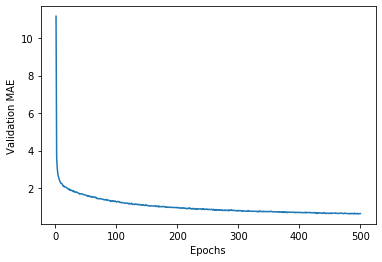

In [13]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()